In [2]:
%pip install tsfel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 635.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.3 MB/s eta 0:00:00


In [39]:
import os
import numpy as np
import pandas as pd
import tsfel
from sklearn import tree
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from FeatureExtractor.extractor import extract #Self-made library to extract the necessary features we require

Training the recognizer...
Shape of X_test_collected (Featurized): (24, 28)
Accuracy of the Decision Tree model is:  37.5 %
Displaying Confusion Matrix...


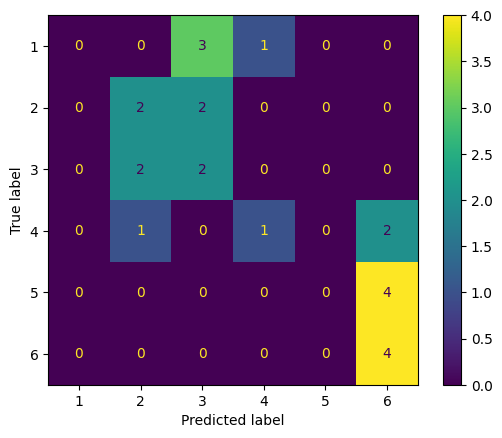

In [40]:
#Important Note: Make sure you have openxlsx library installed since it is used to read and extract data from .xlsx files from the directory. This can be done using !pip install openxlsx



classes = {"Walking":1,"WalkingUpstairs":2,"WalkingDownstairs":3,"Sitting":4,"Standing":5,"Laying":6}  #Dictionary to define the classification of the activity

X_test_collected_ax = []
X_test_collected_ay = []
X_test_collected_az = []
y_test_collected = []
print("Training the recognizer...")

for folder in classes.keys():
    files = os.listdir("/content/Collected-Data/"+folder)
    for file in files:
        path = "/content/Collected-Data/" + folder + "/" + file

        try:
            df = pd.read_excel(path)
        except:
            df = pd.read_csv(path)

        df = df[0:500]
        df.columns = ['time','ax','ay','az','at']

        X_test_collected_ax.append(np.array(df['ax']))
        X_test_collected_ay.append(np.array(df['ay']))
        X_test_collected_az.append(np.array(df['az']))
        y_test_collected.append(classes[folder])

X_test_collected_temp = []

#Making an 3D array to feed to extract to get the required features
for i in range(len(X_test_collected_ay)):
    temp = []
    for j in range(500):
        temp.append([X_test_collected_ax[i][j],X_test_collected_ay[i][j],X_test_collected_az[i][j]])
    X_test_collected_temp.append(temp)

X_test_collected = np.array(X_test_collected_temp)

X_test_collected = extract(X_test_collected)  # Extract takes a 3D Array and returs an 2D array with the selected features
print("Shape of X_test_collected (Featurized):",X_test_collected.shape)


#Loading the data
X_train = np.load('/content/X_train.npy')
y_train = np.load('/content/y_train.npy')
X_test = np.load('/content/X_test.npy')
y_test = np.load('/content/y_test.npy')
X_val = np.load('/content/X_val.npy')
y_val = np.load('/content/y_val.npy')


#Appending everything into the X_Data
X_data = []
for i in range(len(X_test)):
    X_data.append(X_test[i])

for i in range(len(X_train)):
    X_data.append(X_train[i])

for i in range(len(X_val)):
    X_data.append(X_val[i])

X_train = extract(X_data)
y_train = np.array(list(y_test)+list(y_train)+list(y_val))


Recognizer = tree.DecisionTreeClassifier(max_depth=4, min_samples_split=2, criterion='gini', random_state=43)
Recognizer.fit(X_train, y_train)

y_pred = Recognizer.predict(X_test_collected)
accuracy = accuracy_score(y_test_collected,y_pred)
print("Accuracy of the Decision Tree model is: ",accuracy*100,"%")
con_mat = confusion_matrix(y_test_collected,y_pred, labels=Recognizer.classes_)
print("Displaying Confusion Matrix...")
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat,display_labels=Recognizer.classes_)
disp.plot()
plt.show()


In [41]:
x_train_sig = list(X_data)
X_test_collected_temp = list(X_test_collected_temp)

In [42]:
fs=50

cfg_file = tsfel.get_features_by_domain()                # All features
# cfg_file = tsfel.get_features_by_domain('statistical') # Only statistical features
# cfg_file = tsfel.get_features_by_domain('temporal')    # Only temporal features
# cfg_file = tsfel.get_features_by_domain('spectral')    # Only spectral features

# Get features
X_train = tsfel.time_series_features_extractor(cfg_file, x_train_sig, fs=fs)
X_test = tsfel.time_series_features_extractor(cfg_file, X_test_collected_temp, fs=fs)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [43]:
print(X_train.shape)
print(X_test.shape)

(180, 1152)
(24, 1152)


In [44]:
corr_features = tsfel.correlated_features(X_train)
X_train.drop(corr_features, axis=1, inplace=True)
X_test.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

# Normalising Features
scaler = preprocessing.StandardScaler()
nX_train = scaler.fit_transform(X_train)
nX_test = scaler.transform(X_test)

In [45]:
from sklearn import tree
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
classifier = tree.DecisionTreeClassifier()
classifier = classifier.fit(nX_train, y_train.ravel())

Accuracy: 29.166666666666668%
Displaying Confusion Matrix...


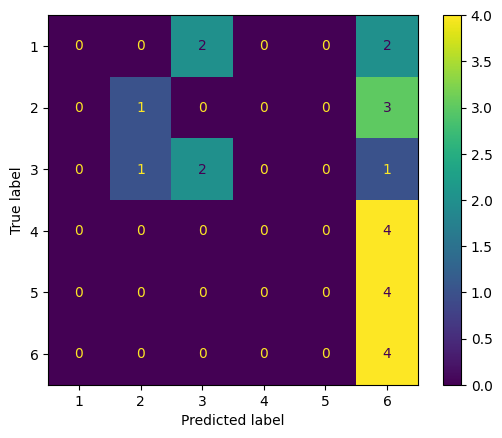

In [46]:
y_test_predict = classifier.predict(nX_test)

# Get the classification report
accuracy = accuracy_score(y_test_collected, y_test_predict) * 100
# print(classification_report(y_test, y_test_predict, target_names=activity_labels))
print("Accuracy: " + str(accuracy) + '%')
con_mat = confusion_matrix(y_test_collected,y_test_predict, labels=classifier.classes_)
print("Displaying Confusion Matrix...")
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat,display_labels=classifier.classes_)
disp.plot()
plt.show()

After training the model on the features (from extractor) we used the Collected-data to predict the activity and found the acccuracy to be 37.5%. Using the featiures obtained from tsfel library, we obtained even lower accuracy of 30%. This is counter intuitive and is in sharp contrast to the trend observed while using the UCI-HAR dataset where the features provided by tsfel provided a far clear picture. The reason for low accuracy and the counter intuitive trend can be following:
- We have used only 28 features to train the model, but the UCI HAR paper has used 561 features to train and hence predict.
- They have used filters like Butterworth features in order to remove the noises from the collected data in order to achieve better accuracy.
- We haven't deployed the 5-Fold Cross Validation whislt the author of the paper have included it.